# Overview

Initial look and cleaning and seperating of data complete.

To accomplish: 

- ~~select better model for fitting~~
- ~~select cleaner way to impute data~~
- ~~make month specific predictions (opt)~~
- try pca
- feature engineering
- month by month predictions for the training data

# Initial Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
zillow_data_dictionary = pd.read_excel('data/zillow_data_dictionary.xlsx')
train_2016 = pd.read_csv('data/train_2016_v2.csv')
properties_2016 = pd.read_csv('data/properties_2016.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

C:\Users\Josh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Zillow Data Dictionary

##### zdd is a description of each of the features available for analysis

In [3]:
zillow_data_dictionary.head(20)

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the buildi...
6,'buildingclasstypeid',"The building framing type (steel frame, wood f..."
7,'calculatedbathnbr',Number of bathrooms in home including fractio...
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + si...


In [4]:
zdd = zillow_data_dictionary

In [5]:
zdd['Feature'].unique()

array(["'airconditioningtypeid'", "'architecturalstyletypeid'",
       "'basementsqft'", "'bathroomcnt'", "'bedroomcnt'",
       "'buildingqualitytypeid'", "'buildingclasstypeid'",
       "'calculatedbathnbr'", "'decktypeid'", "'threequarterbathnbr'",
       "'finishedfloor1squarefeet'", "'calculatedfinishedsquarefeet'",
       "'finishedsquarefeet6'", "'finishedsquarefeet12'",
       "'finishedsquarefeet13'", "'finishedsquarefeet15'",
       "'finishedsquarefeet50'", "'fips'", "'fireplacecnt'",
       "'fireplaceflag'", "'fullbathcnt'", "'garagecarcnt'",
       "'garagetotalsqft'", "'hashottuborspa'", "'heatingorsystemtypeid'",
       "'latitude'", "'longitude'", "'lotsizesquarefeet'",
       "'numberofstories'", "'parcelid'", "'poolcnt'", "'poolsizesum'",
       "'pooltypeid10'", "'pooltypeid2'", "'pooltypeid7'",
       "'propertycountylandusecode'", "'propertylandusetypeid'",
       "'propertyzoningdesc'", "'rawcensustractandblock'",
       "'censustractandblock'", "'regionidcounty'

In [6]:
zdd.loc[0][0]

"'airconditioningtypeid'"

In [7]:
zdd.loc[0][1]

' Type of cooling system present in the home (if any)'

# Train 2016

### All of the train information from 2016

- parcel id
- log error
- transaction date
- month

In [8]:
train_2016.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [9]:
train = train_2016

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Data columns (total 3 columns):
parcelid           90275 non-null int64
logerror           90275 non-null float64
transactiondate    90275 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ MB


In [11]:
int(train.loc[0][2].split('-')[1]) #Extracting the month

1

In [12]:
#create month column - numeric
train['month']=train['transactiondate'].apply(lambda date: int(date.split('-')[1])) 

In [13]:
train.drop('transactiondate',axis=1,inplace=True)

In [14]:
train.head(1)

,parcelid,logerror,month
0,11016594,0.0276,1


In [15]:
train.groupby('month').mean()

,parcelid,logerror
month,,
1,1.291135e+07,0.015870
2,1.296204e+07,0.016082
3,1.299837e+07,0.009867
4,1.300473e+07,0.006605
5,1.304167e+07,0.006926
6,1.303634e+07,0.007172
7,1.298525e+07,0.011687
8,1.299474e+07,0.011573
9,1.294000e+07,0.016255


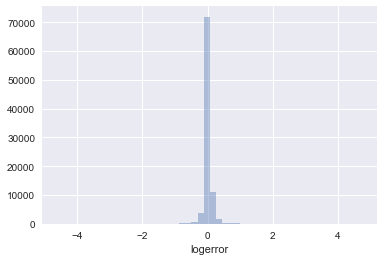

In [16]:
sns.distplot(train['logerror'],kde=False)

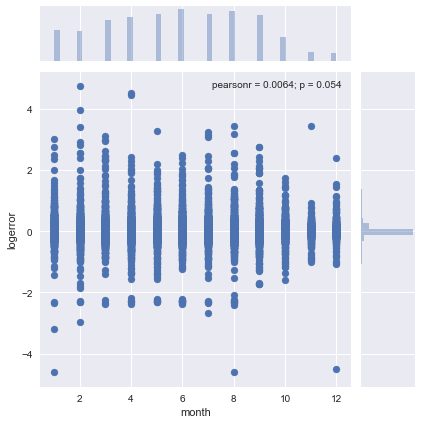

In [17]:
sns.jointplot(x='month',y='logerror',data=train)

C:\Users\Josh\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


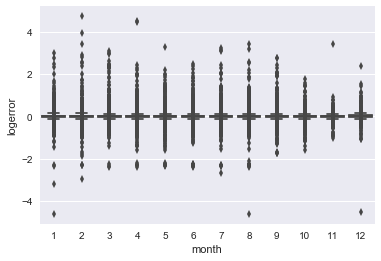

In [18]:
sns.boxplot(x='month',y='logerror',data=train)

# Propeties 2016

### Property data

1 id column
57 feature columns

In [19]:
prop_train = pd.merge(properties_2016,train_2016,how='inner',on='parcelid')

In [20]:
prop_train.head(1)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,month
0,17073783,NaN,NaN,NaN,2.5,3.0,NaN,NaN,2.5,NaN,...,115087.0,191811.0,2015.0,76724.0,2015.06,NaN,NaN,6.111002e+13,0.0953,1


In [21]:
prop=properties_2016

In [22]:
prop.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


C:\Users\Josh\Anaconda3\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


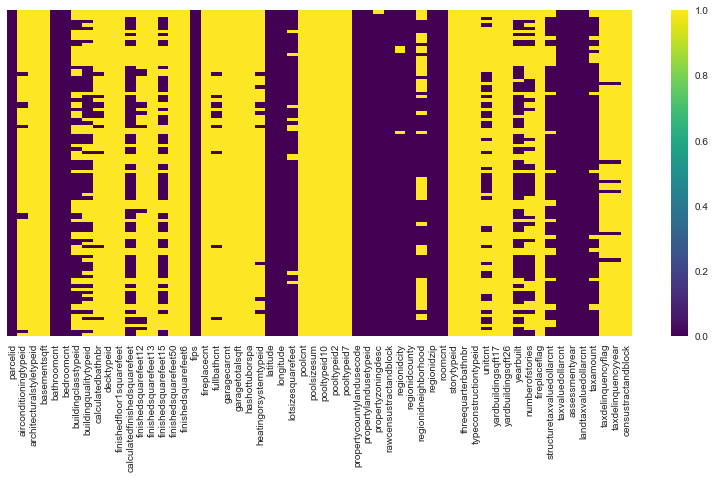

In [23]:
#looking at missing values
plt.figure(figsize=(14,6))
sns.heatmap(prop.iloc[0:100].isnull(),yticklabels=False,cmap='viridis')

In [24]:
missing_df = prop.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column name', 'missing count']
missing_df = missing_df.sort_values(by='missing count',ascending=True)
missing_df.head(15)

,column name,missing count
0,parcelid,0
17,fips,11437
33,propertylandusetypeid,11437
35,rawcensustractandblock,11437
37,regionidcounty,11437
25,longitude,11437
24,latitude,11437
52,assessmentyear,11439
5,bedroomcnt,11450
4,bathroomcnt,11462


In [25]:
rarely_missing_data_columns=list(prop.dropna(axis=1,thresh=2970000).columns) #Columns with rarely missing data (<10)
rarely_missing_data_columns

['parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'fips',
 'latitude',
 'longitude',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcounty',
 'regionidzip',
 'roomcnt',
 'assessmentyear']

In [26]:
len(rarely_missing_data_columns)

13

In [27]:
prop = prop[rarely_missing_data_columns]

In [28]:
#looking at missing values
#plt.figure(figsize=(14,6))
#sns.heatmap(prop.isnull(),yticklabels=False,cmap='viridis')

#### Deal with missing data

In [29]:
for column in prop.columns:
    print("Imputing {} to {}".format(prop[column].value_counts().idxmax(),column))
    prop[column].fillna(prop[column].value_counts().idxmax(), inplace=True)

Imputing 12584959 to parcelid


C:\Users\Josh\Anaconda3\lib\site-packages\pandas\core\generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Imputing 2.0 to bathroomcnt
Imputing 3.0 to bedroomcnt
Imputing 6037.0 to fips
Imputing 33984600.0 to latitude
Imputing -118390000.0 to longitude
Imputing 0100 to propertycountylandusecode
Imputing 261.0 to propertylandusetypeid
Imputing 60590524.262052 to rawcensustractandblock
Imputing 3101.0 to regionidcounty
Imputing 96987.0 to regionidzip
Imputing 0.0 to roomcnt
Imputing 2015.0 to assessmentyear


In [67]:
prop[prop.isnull().any(axis=1)==True].head() #No more null statements

,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidzip,roomcnt,assessmentyear


# Further visualization with cleaned subset

C:\Users\Josh\Anaconda3\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\Users\Josh\Anaconda3\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


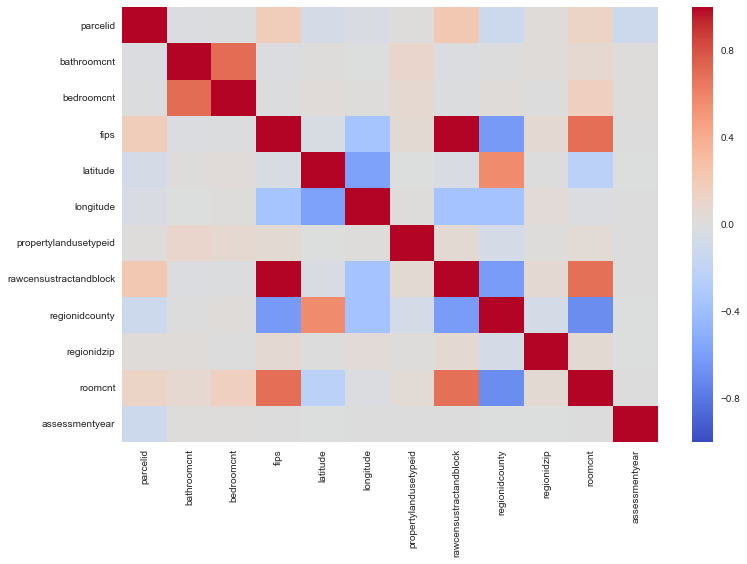

In [31]:
plt.figure(figsize=(12,8))
sns.heatmap(prop.corr(),cmap='coolwarm')

# Trim and transform data

In [32]:
def remove_outliers(old_df,number_of_std,columns="All",skip="None"):
    """
    Removes outliers from a dataframe.
    
    Parameters:
    old_df: Series or dataframe
    
    number_of_std: Number of standard deviations for threshhold. 
                   Function will remove all outliers beyond this many standard deviations.
                   
    columns: The columns upon which the operation will be performed. (List of column names)
    
    skip: List of columns to be skipped.
    
    Returns:
    A dataframe with the outliers removed.
    
    """
    
    if isinstance(old_df,pd.core.series.Series): #If series passed, then only 
        current_series = old_df #set current series
        
        mean = np.mean(current_series)    #Mean
        std = np.std(current_series)      #Std
        threshold = number_of_std*std     #Threshhold = number of std * std
        
        new_df = old_df[np.abs(current_series-mean)<threshold] #Remove outliers from series
    else:
        if columns=="All": #Set columns
            columns=old_df.columns
            
        if skip!="None": #Skip any columns to be skipped
            columns = [name for name in list(old_df.columns) if name not in skip]
        
        for column in columns:
            current_series = old_df[column] #Iterate through each column

            mean = np.mean(current_series) #Set up threshold for which x should be within
            std = np.std(current_series)
            threshold = number_of_std*std

            new_df = old_df[np.abs(current_series-mean)<threshold] #Remove outliers from this column
    
    return new_df

In [33]:
prop['assessmentyear'].unique()

array([ 2015.,  2014.,  2003.,  2012.,  2001.,  2011.,  2013.,  2016.,
        2010.,  2004.,  2005.,  2002.,  2000.,  2009.])

In [34]:
#prop = remove_outliers(prop,3,skip=['parcelid','regionidzip','assessmentyear']) 

# Feature engineering

In [35]:
#prop.columns

#None at present

#Add train month

X_train['evaluation_month']=

# Dummy variables

In [36]:
#prop_with_dummies = pd.concat([prop,pd.get_dummies(prop[['propertycountylandusecode','regionidzip']],drop_first=True)], axis=1)

# Setting y_train and aligning x_train and y_train

#### Seperate properties with pricing data from properties without pricing data

In [37]:
#prop=prop_with_dummies

In [108]:
X_train = prop[prop['parcelid'].isin(train_2016['parcelid'])]
X_test = prop[~prop['parcelid'].isin(train_2016['parcelid'])]

y_train = train_2016.groupby('parcelid')['logerror'].mean()

In [109]:
#Aligning train_y and train_x
X_train = X_train.sort_values('parcelid')
y_train = y_train.reset_index().sort_values('parcelid')

In [110]:
#Create month column
X_train['month']=train.sort_values(by='parcelid')['month']

# Model: XGBoost

#### Initial set-up

In [111]:
features =list(X_train.columns)

features.remove('propertycountylandusecode')


X_test['month']=""
X_test=X_test[features]

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x0000026B2B6E2400>>
Traceback (most recent call last):
  File "C:\Users\Josh\Anaconda3\lib\site-packages\xgboost-0.6-py3.6.egg\xgboost\core.py", line 360, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'
C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [112]:
Xtr, Xv, ytr, yv = train_test_split(X_train[features].drop('parcelid',axis=1).values, 
                                    y_train.drop('parcelid',axis=1).values, 
                                    test_size=0.2, random_state=42)

In [113]:
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)

watchlist = [(dtrain,'dtrain'),(dvalid,'dvalid')]

#### Gridsearch parameters for XGBoost

In [114]:
from sklearn.model_selection import GridSearchCV

In [115]:
param_grid = [{'min_child_weight':[1,10],'max_depth':[10]}]

xgb_model = xgb.XGBRegressor(n_jobs=-1)

grid_search = GridSearchCV(xgb_model, param_grid, cv=3,verbose=1)

grid_search.fit(X_train[features].drop('parcelid',axis=1),y_train.drop('parcelid',axis=1))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   30.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'min_child_weight': [1, 10], 'max_depth': [10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [116]:
params = grid_search.best_params_
params

{'max_depth': 10, 'min_child_weight': 10}

#### Train XGBoost

In [117]:
xgbr = xgb.train(params=params,
                 dtrain=dtrain,
                 num_boost_round=100,
                 evals=watchlist,
                 early_stopping_rounds=30,
                 maximize=False,
                verbose_eval=10)

[0]	dtrain-rmse:0.377161	dvalid-rmse:0.38094
Multiple eval metrics have been passed: 'dvalid-rmse' will be used for early stopping.

Will train until dvalid-rmse hasn't improved in 30 rounds.
[10]	dtrain-rmse:0.154765	dvalid-rmse:0.165321
[20]	dtrain-rmse:0.152916	dvalid-rmse:0.164943
[30]	dtrain-rmse:0.15173	dvalid-rmse:0.165207
[40]	dtrain-rmse:0.150687	dvalid-rmse:0.165465
Stopping. Best iteration:
[15]	dtrain-rmse:0.153557	dvalid-rmse:0.164835



In [118]:
xgbr.best_score

0.164835

#### Feature Importance

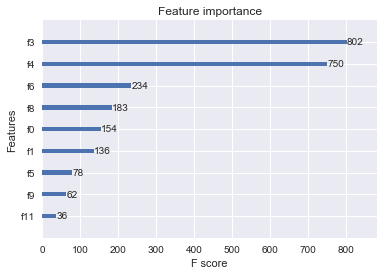

In [119]:
xgb.plot_importance(xgbr,max_num_features=20)

In [120]:
feature_importance_dict = xgbr.get_fscore()
feature_importance = pd.DataFrame({'feature': list(feature_importance_dict.keys()),
                                   'importance': list(feature_importance_dict.values())})
feature_importance['feature']=feature_importance['feature'].apply(lambda feature_id: features[int(list(feature_id)[1])])

feature_importance[['feature', 'importance']].sort_values(by='importance', ascending=False)

,feature,importance
1,fips,802
2,latitude,750
5,propertylandusetypeid,234
3,regionidcounty,183
0,parcelid,154
4,bathroomcnt,136
8,longitude,78
7,regionidzip,62
6,bathroomcnt,36


# Predictions

#### Create test_pred_df

In [124]:
test_pred_df = pd.DataFrame(data=X_test['parcelid'],columns=['parcelid'])

for year_month in ['201610','201611','201612','201710','201711','201712']:
    X_test['month']=int(year_month[-2:])
    dtest = xgb.DMatrix(X_test.drop('parcelid',axis=1).values)
    test_pred_df[year_month]=xgbr.predict(dtest)

In [125]:
test_pred_df.head(1)

,parcelid,201610,201611,201612,201710,201711,201712
0,10754147,-0.029305,-0.018709,-0.018709,-0.029305,-0.018709,-0.018709


#### Create train_pred_df from train data

In [126]:
train_pred_df = pd.DataFrame(data=y_train['parcelid'],columns=['parcelid'])

#For now - set all predictions alike irrespective of month
for _, year in enumerate(['201610','201611','201612','201710','201711','201712']):
    train_pred_df[year]= y_train['logerror']

train_pred_df.head()
train_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90150 entries, 0 to 90149
Data columns (total 7 columns):
parcelid    90150 non-null int64
201610      90150 non-null float64
201611      90150 non-null float64
201612      90150 non-null float64
201710      90150 non-null float64
201711      90150 non-null float64
201712      90150 non-null float64
dtypes: float64(6), int64(1)
memory usage: 5.5 MB


#### Merge train_pred_df and test_pred_df

In [127]:
sub_df = pd.merge(train_pred_df,test_pred_df,how='outer',on='parcelid')
sub_df.head()

,parcelid,201610_x,201611_x,201612_x,201710_x,201711_x,201712_x,201610_y,201611_y,201612_y,201710_y,201711_y,201712_y
0,10711738,0.0276,0.0276,0.0276,0.0276,0.0276,0.0276,NaN,NaN,NaN,NaN,NaN,NaN
1,10711755,-0.0182,-0.0182,-0.0182,-0.0182,-0.0182,-0.0182,NaN,NaN,NaN,NaN,NaN,NaN
2,10711805,-0.1009,-0.1009,-0.1009,-0.1009,-0.1009,-0.1009,NaN,NaN,NaN,NaN,NaN,NaN
3,10711816,-0.0121,-0.0121,-0.0121,-0.0121,-0.0121,-0.0121,NaN,NaN,NaN,NaN,NaN,NaN
4,10711858,-0.0481,-0.0481,-0.0481,-0.0481,-0.0481,-0.0481,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
#fixing merge since I can't yet merege in a more elegant fashion

sub_df['201610'] = pd.concat([sub_df['201610_x'].dropna(), sub_df['201610_y'].dropna()]).reindex_like(sub_df)
sub_df['201611'] = pd.concat([sub_df['201611_x'].dropna(), sub_df['201611_y'].dropna()]).reindex_like(sub_df)
sub_df['201612'] = pd.concat([sub_df['201612_x'].dropna(), sub_df['201612_y'].dropna()]).reindex_like(sub_df)
sub_df['201710'] = pd.concat([sub_df['201610_x'].dropna(), sub_df['201610_y'].dropna()]).reindex_like(sub_df)
sub_df['201711'] = pd.concat([sub_df['201611_x'].dropna(), sub_df['201611_y'].dropna()]).reindex_like(sub_df)
sub_df['201712'] = pd.concat([sub_df['201612_x'].dropna(), sub_df['201612_y'].dropna()]).reindex_like(sub_df)

sub_df.drop(['201610_x', '201611_x', '201612_x', '201710_x', 
             '201711_x','201712_x', '201610_y', '201611_y', 
             '201612_y', '201710_y', '201711_y','201712_y'],axis=1,inplace=True)

#### Sanity check

In [129]:
len(sub_df)

2985217

In [130]:
len(properties_2016)

2985217

In [131]:
sample_submission.head(1)

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0


In [132]:
sub_df.head(1)

,parcelid,201610,201611,201612,201710,201711,201712
0,10711738,0.0276,0.0276,0.0276,0.0276,0.0276,0.0276


#### Convert to csv

In [133]:
sub_df.to_csv('Zillow 3 - XGBoost 3.csv',index=False)